# k近邻

导入相关的 package 和设定绘图参数

In [1]:
import numpy as np
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

以 iris 数据集为例

In [2]:
X, y = shuffle(datasets.load_iris().data, datasets.load_iris().target, random_state=13)
X = X.astype(np.float32)
# 训练集与测试集的简单划分
offset = int(X.shape[0] * 0.7)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

print('X_train=', X_train.shape)
print('X_test=', X_test.shape)
print('y_train=', y_train.shape)
print('y_test=', y_test.shape)

X_train= (105, 4)
X_test= (45, 4)
y_train= (105, 1)
y_test= (45, 1)


定义 L2 距离度量函数

In [3]:
def compute_distances(X, X_train):
    num_test = X.shape[0]
    num_train = X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 

    M = np.dot(X, X_train.T)
    te = np.square(X).sum(axis=1)
    tr = np.square(X_train).sum(axis=1)
    dists = np.sqrt(-2 * M + tr + np.matrix(te).T)    
    return dists

计算测试集与训练集实例的距离

In [4]:
dists = compute_distances(X_test,X_train)
print(dists.shape)

(45, 105)


距离矩阵进行可视化展示

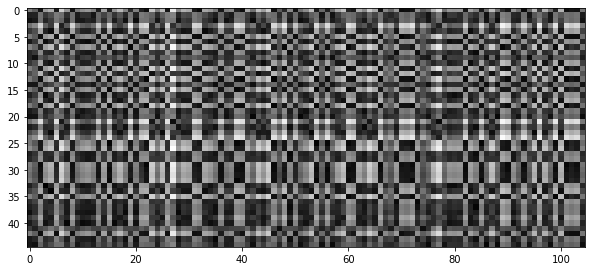

In [5]:
plt.imshow(dists, interpolation='none')
plt.show()

使用多数表决的分类决策规则定义预测函数，这里假设 k 值取 1

In [6]:
def predict_labels(y_train, dists, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)    
    for i in range(num_test):

        closest_y = []
        # 注意 argsort 函数的用法
        labels = y_train[np.argsort(dists[i, :])].flatten()
        closest_y = labels[0:k]

        c = Counter(closest_y)
        y_pred[i] = c.most_common(1)[0][0]    
    return y_pred

预测测试集的类别准确率

In [8]:
y_test_pred = predict_labels(y_train,dists, k=1)
y_test_pred = y_test_pred.reshape((-1, 1))
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / X_test.shape[0]
print('Got %d / %d correct => accuracy: %f' % (num_correct, X_test.shape[0], accuracy))

Got 44 / 45 correct => accuracy: 0.977778


使用 5 折交叉验证来选择最优的 k 值

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)
k_to_accuracies = {}
for k in k_choices:    
    for fold in range(num_folds): 
        # 对传入的训练集单独划出一个验证集作为测试集
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])       
        # 计算距离
        temp_dists = compute_distances(validation_X_test,temp_X_train)
        temp_y_test_pred = predict_labels(temp_y_train,temp_dists, k=k)
        temp_y_test_pred = temp_y_test_pred.reshape((-1, 1))       
        # 查看分类准确率
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]
      
 
# 打印不同 k 值不同折数下的分类准确率
for k in sorted(k_to_accuracies):    
      for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.904762
k = 1, accuracy = 1.000000
k = 1, accuracy = 0.952381
k = 1, accuracy = 0.857143
k = 1, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 1.000000
k = 3, accuracy = 0.952381
k = 3, accuracy = 0.857143
k = 3, accuracy = 0.952381
k = 5, accuracy = 0.857143
k = 5, accuracy = 1.000000
k = 5, accuracy = 0.952381
k = 5, accuracy = 0.904762
k = 5, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 1.000000
k = 8, accuracy = 0.952381
k = 8, accuracy = 0.904762
k = 8, accuracy = 0.952381
k = 10, accuracy = 0.952381
k = 10, accuracy = 1.000000
k = 10, accuracy = 0.952381
k = 10, accuracy = 0.904762
k = 10, accuracy = 0.952381
k = 12, accuracy = 0.952381
k = 12, accuracy = 1.000000
k = 12, accuracy = 0.952381
k = 12, accuracy = 0.857143
k = 12, accuracy = 0.952381
k = 15, accuracy = 0.952381
k = 15, accuracy = 1.000000
k = 15, accuracy = 0.952381
k = 15, accuracy = 0.857143
k = 15, accuracy = 0.952381
k = 20, accuracy = 0.952381
k = 20, accu

对不同 k 值下的分类准确率进行可视化展示

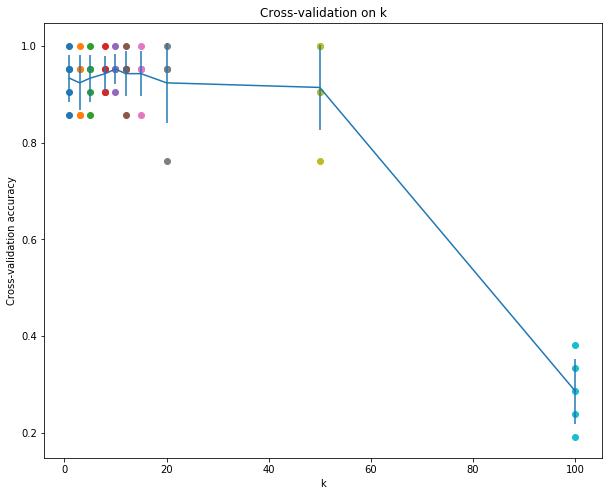

In [13]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

查看最佳 k 值大小

In [15]:
best_k = k_choices[np.argmax(accuracies_mean)]
print("最佳k值为",best_k)

最佳k值为 10
